In [39]:

# designing and implementing feedforward NN in PyTorch to classify fashionMNIST

# accuracy = 35%


# to use your own images with pytorch you might need to put them in their own class, as set out:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# under 'Creating a Custom Dataset for your files'



# transforming data (eg: to normalise)
# https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html




# arguing that fashionMNIST is a better choice than MNIST:
# https://github.com/zalandoresearch/fashion-mnists

import numpy as np
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor    # ToTensor converts PIL image or nparray to FloatTensor



In [47]:
X = torch.rand(1, 10)
print(X)                      # random vector of 10 values, which could be NN outputs for 10-class classifier
print(nn.Softmax(dim=1)(X))   # may wish to put outputs of NN through softmax
print(torch.sum(nn.Softmax(dim=1)(X)))   # showing softmax outputs sum to 1

tensor([[0.4514, 0.5145, 0.1621, 0.5151, 0.9154, 0.7347, 0.6770, 0.1456, 0.8674,
         0.6700]])
tensor([[0.0866, 0.0922, 0.0648, 0.0923, 0.1377, 0.1150, 0.1085, 0.0638, 0.1313,
         0.1078]])
tensor(1.0000)


In [4]:
# get data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)



Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...


/usr/local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [5]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

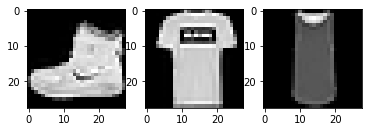

In [38]:
# see first 3 images in training data set
plt.subplot(1,3,1)    
plt.imshow(training_data[0][0][0, :, :], cmap="gray")
plt.subplot(1,3,2)    
plt.imshow(training_data[1][0][0, :, :], cmap="gray")
plt.subplot(1,3,3)    
plt.imshow(training_data[2][0][0, :, :], cmap="gray")
plt.show()

In [8]:
batch_size = 64 # minibatch size

train_dataloader = DataLoader(training_data, batch_size=batch_size) # creates python iterable over dataset
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(   # container of sequential operations
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """flatten input and return 10 values at end of sequence, as there are 10 classes"""
        x = self.flatten(x)
        logits = self.linear_relu_stack(x) 
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [12]:
loss_fn = nn.CrossEntropyLoss()     # chosing loss function 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # set optimiser with learning rate

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    """Single training epoch, looping through mini-batches as set in dataloader obj"""
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()  # setting weights to zero - not sure if doing this on every epoch or not
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:     # printing diagnostics on every 100th batch
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
def test(dataloader, model, loss_fn):
    """test performance of model on test dataset"""
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()    # puts the model into eval model (instead of train); a form of switch
    test_loss, correct = 0, 0
    with torch.no_grad():    # no_grad disables gradient calculation
                               # anytime we're applying the model, put it within no_grad so no updates made
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)         
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches   # shorthand for: test_loss = test_loss / num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [29]:
### training process
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)   
    test(test_dataloader, model, loss_fn)   # tells you how it's doing
print("Done!")

Epoch 1
-------------------------------
loss: 2.175393  [    0/60000]
loss: 2.188902  [ 6400/60000]
loss: 2.164962  [12800/60000]
loss: 2.195203  [19200/60000]
loss: 2.164782  [25600/60000]
loss: 2.152572  [32000/60000]
loss: 2.183286  [38400/60000]
loss: 2.161990  [44800/60000]
loss: 2.178070  [51200/60000]
loss: 2.157706  [57600/60000]
Test Error: 
 Accuracy: 35.3%, Avg loss: 2.167707 

Epoch 2
-------------------------------
loss: 2.175393  [    0/60000]
loss: 2.188902  [ 6400/60000]
loss: 2.164962  [12800/60000]
loss: 2.195203  [19200/60000]
loss: 2.164782  [25600/60000]
loss: 2.152572  [32000/60000]
loss: 2.183286  [38400/60000]
loss: 2.161990  [44800/60000]
loss: 2.178070  [51200/60000]
loss: 2.157706  [57600/60000]
Test Error: 
 Accuracy: 35.3%, Avg loss: 2.167707 

Epoch 3
-------------------------------
loss: 2.175393  [    0/60000]
loss: 2.188902  [ 6400/60000]
loss: 2.164962  [12800/60000]
loss: 2.195203  [19200/60000]
loss: 2.164782  [25600/60000]
loss: 2.152572  [32000/600

In [17]:
torch.save(model.state_dict(), "model.pth")  # saving model


# loading model involves initialising a network and loading the .pth model state into it
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [49]:
# making a prediction for a single data point
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()    # eval mode is also prediction mode
x, y = test_data[1][0], test_data[0][1]
print(x.shape)
print(y)
softmax = nn.Softmax(dim=1)  # defining softmax for our uses
with torch.no_grad():    # anytime we're applying the model, put it within no_grad so no updates made
    pred = model(x)
    pred = softmax(pred)   # effectively rescales to sum to 1 (tho not necessary to pick the highest scorer)
    print(pred)
    print('class with highest prediction: ' + str(classes[pred[0].argmax(0)]))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

torch.Size([1, 28, 28])
9
tensor([[0.1031, 0.0832, 0.1421, 0.0797, 0.1332, 0.0744, 0.1154, 0.0743, 0.0997,
         0.0950]])
class with highest prediction: Pullover
Predicted: "Pullover", Actual: "Ankle boot"


In [50]:
# view weights for each layer
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0212,  0.0024,  0.0211,  ...,  0.0309, -0.0109,  0.0190],
        [ 0.0290,  0.0011, -0.0206,  ..., -0.0036, -0.0340, -0.0131]],
       grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0245, -0.0284], grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0139, -0.0065, -0.0233,  ..., -0.0002,  0.0407,  0.0092],
        [-0.0320,  0.0230, -0.0432,  ...,  0.0001, -0.0395,  0.0131]],
       grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.2.bias | S